In [78]:
library(MuSiC)
library(Biobase)
library(Matrix)
library(Seurat)
library(xbioc)
library(dplyr)
library(reshape2)
library(wesanderson)
library(BBmisc)
library(tidyr)

In [79]:
#Function for grouping variables on one line

# Generic form
'%=%' = function(l, r, ...) UseMethod('%=%')

# Binary Operator
'%=%.lbunch' = function(l, r, ...) {
  Envir = as.environment(-1)

  if (length(r) > length(l))
    warning("RHS has more args than LHS. Only first", length(l), "used.")

  if (length(l) > length(r))  {
    warning("LHS has more args than RHS. RHS will be repeated.")
    r <- extendToMatch(r, l)
  }

  for (II in 1:length(l)) {
    do.call('<-', list(l[[II]], r[[II]]), envir=Envir)
  }
}

# Used if LHS is larger than RHS
extendToMatch <- function(source, destin) {
  s <- length(source)
  d <- length(destin)

  # Assume that destin is a length when it is a single number and source is not
  if(d==1 && s>1 && !is.null(as.numeric(destin)))
    d <- destin

  dif <- d - s
  if (dif > 0) {
    source <- rep(source, ceiling(d/s))[1:d]
  }
  return (source)
}
# Grouping the left hand side
g = function(...) {
  List = as.list(substitute(list(...)))[-1L]
  class(List) = 'lbunch'
  return(List)
}

In [123]:
#import scRNAseq data

setwd('~/GCA_analysis/datasets')
gca<-readRDS('GCA_R.RDS')

Idents(gca)<-'anno'

tissue<-subset(gca, id = c('MyoFB_tissue', 'VSMC_tissue', 'Mac1_tissue','CD4_1_tissue',
                           'Transitional_tissue','NK_tissue','Mac2_tissue',
                            'Endothelium_2_tissue','Endothelium_1_tissue','CD8_tissue',
                           'Lymph_endo_tissue','CD4_2_tissue',
                            'DC_tissue','Epithelium_tissue','Plasma_tissue',
                           'CD4_exhausted_tissue','Transitional_tissue',
                            'Melanocyte_tissue','Muscle_tissue'))

#remove small populations and Transitional - mixed VSMC/MyoFB signature cannot be distinguished

tissue<-subset(tissue, id = c('Epithelium_tissue', 'Melanocyte_tissue','Muscle_tissue',
                              'Plasma_tissue', 'Transitional_tissue', 'Lymph_endo_tissue'), invert = TRUE)

tissue@meta.data$anno<-gsub('_tissue', '', tissue@meta.data$anno)

In [125]:
tissue<-NormalizeData(tissue)

In [126]:
anno<-'anno'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_1']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_2']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD4_exhausted']<-'CD4'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'CD8']<-'CD8'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'NK']<-'NK'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Endothelium_1']<-'Endothelium'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Endothelium_2']<-'Endothelium'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Lymph_endo']<-'Lymph_endo'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Mac1']<-'Mac'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'Mac2']<-'Mac'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'DC']<-'DC'

tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'MyoFB']<-'MyoFB'
tissue@meta.data[[anno]][tissue@meta.data[[anno]] == 'VSMC']<-'VSMC'

In [127]:
#create expressionSet from scRNAseq data

raw<-GetAssayData(tissue, slot = 'counts')

meta<-tissue@meta.data['anno']

sc<-new("ExpressionSet", exprs=as.matrix(raw), phenoData = AnnotatedDataFrame(data=tissue@meta.data))

In [128]:
unique(tissue@meta.data$anno)

[1] "VSMC"        "MyoFB"       "Mac"         "CD4"         "NK"         
[6] "Endothelium" "CD8"         "DC"

In [132]:
#use this to group the clusters, calculate DEGs between then and use this to improve the algorithm's ability
#to distinguish those groups

clusters.type = list(C1 = c('VSMC', 'MyoFB', 'Endothelium'), 
                     C2 = c('CD4', 'CD8', 'NK'), 
                     C3 = c('DC', 'Mac'))

cl.type = as.character(sc$anno)

for(cl in 1:length(clusters.type)){
  cl.type[cl.type %in% clusters.type[[cl]]] = names(clusters.type)[cl]
}
pData(sc)$clusterType = factor(cl.type, levels = c(names(clusters.type), 'CD-Trans', 'Novel1', 'Novel2'))


In [133]:
subtypes_gca = unlist(clusters.type)

In [135]:
#Use the Seurat object to calculate DEGs between the closely related groups

Idents(tissue)<-'anno'

temp<-subset(tissue, id = clusters.type$C1)
C1_genes<-FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)
temp<-subset(tissue, id = clusters.type$C2)
C2_genes<-FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)
temp<-subset(tissue, id = clusters.type$C3)
C3_genes<-FindAllMarkers(temp, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, min.diff.pct = 0.25)


Calculating cluster VSMC

Calculating cluster MyoFB

Calculating cluster Endothelium

Calculating cluster CD4

Calculating cluster NK

Calculating cluster CD8

Calculating cluster Mac

Calculating cluster DC



In [139]:
diff_genes<-list((C1_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
                 (C2_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene,
                 (C3_genes %>% group_by(cluster) %>% slice_max(order_by = avg_log2FC, n = 20))$gene)
names(diff_genes)<-c('C1', 'C2', 'C3')

In [151]:
#Nagal cohort

setwd('~/GCA_analysis/bulk_data')
bulk_data<-read.csv('GSE174694_matrix_temposeq.txt', row.names = 1, sep = '\t')

#bulk_data$NORMAL.VZV..20<-NULL
bulk_data$GCA.VZV..1.1<-NULL
bulk_data$GCA.VZV..9.1<-NULL
bulk_data$NORMAL.VZV..1<-NULL
bulk_data$NORMAL.VZV..17<-NULL
bulk_data$NORMAL.VZV..7<-NULL
bulk_data$NORMAL.VZV..3.1<-NULL

#add metadata
metadata<-data.frame(sample = colnames(bulk_data), diagnosis = sapply(strsplit(colnames(bulk_data), split = '[.]'), "[", 1))
rownames(metadata)<-metadata$sample
metadata$sample<-NULL


#create expressionSet from bulk data

bulk<-new("ExpressionSet", exprs=as.matrix(bulk_data), phenoData = AnnotatedDataFrame(data=metadata))

In [152]:
estimated_bulks = music_prop.cluster(bulk.eset = bulk, 
                                    sc.eset = sc, 
                                    group.markers = diff_genes, 
                                    clusters = 'anno', 
                                    samples = 'patient_id', 
                                    groups = 'clusterType',
                                    clusters.type = clusters.type)





Start: cluster estimations...

Creating Relative Abundance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...

Start: cell type estimations...

Creating Relative Abundance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...

Used 15447 common genes...

GCA.VZV..1 has common genes 6339 ...

GCA.VZV..10 has common genes 9215 ...

GCA.VZV..11 has common genes 7208 ...

GCA.VZV..12 has common genes 10448 ...

GCA.VZV..13 has common genes 12177 ...

GCA.VZV..14 has common genes 9750 ...

GCA.VZV..15 has common genes 5856 ...

GCA.VZV..16 has common genes 12036 ...

GCA.VZV..17 has common genes 10600 ...

GCA.VZV..18 has common genes 11051 ...

GCA.VZV..19 has common genes 11507 ...

GCA.VZV..2 has common genes 7716 ...

GCA.VZV..20 has common genes 11811 ...

GCA.VZV..3 has common genes 7881 ...

GCA.VZV..4 has common genes 11216 ...

GCA.VZV..5 has common genes 9393 ...

GCA.VZV..6 has common genes 9428 ...

GCA.VZV..7 has common genes 8079 ...

GCA

In [153]:
g(Status, Status1, Status2) %=% c('diagnosis', 'NORMAL', 'GCA')

#g(Status, Status1, Status2) %=% c('visual_loss', 'No_visual_loss', 'Visual_loss')

In [159]:
#Output data
setwd('~/GCA_analysis/stats')
deconv<-as.data.frame(estimated_bulks$Est.prop.weighted.cluster)
write.csv(deconv, 'MaGiC_deconvolution_210929.csv')

In [161]:
#format data
deconv<-as.data.frame(estimated_bulks$Est.prop.weighted.cluster)
deconv[Status]<-metadata[Status]

deconv<-melt(deconv, id = Status)
colnames(deconv)<-c(paste0(Status), 'celltype', 'props')
deconv$props <- as.numeric(deconv$props)

In [176]:
deconv[[Status]] <- factor(deconv[[Status]], levels = rev(c(Status1, Status2)))

In [177]:
head(deconv)

,diagnosis,celltype,props
,<fct>,<fct>,<dbl>
1,GCA,VSMC,0.4638565
2,GCA,VSMC,0.2759080
3,GCA,VSMC,0.2764571
4,GCA,VSMC,0.2772095
5,GCA,VSMC,0.2770363
6,GCA,VSMC,0.2415847


In [186]:
deconv$celltype<-factor(deconv$celltype, levels = c('CD4', 'CD8', 'NK', 'DC', 'Mac',
                                                   'VSMC', 'MyoFB', 'Endothelium'))

Saving 6.67 x 6.67 in image



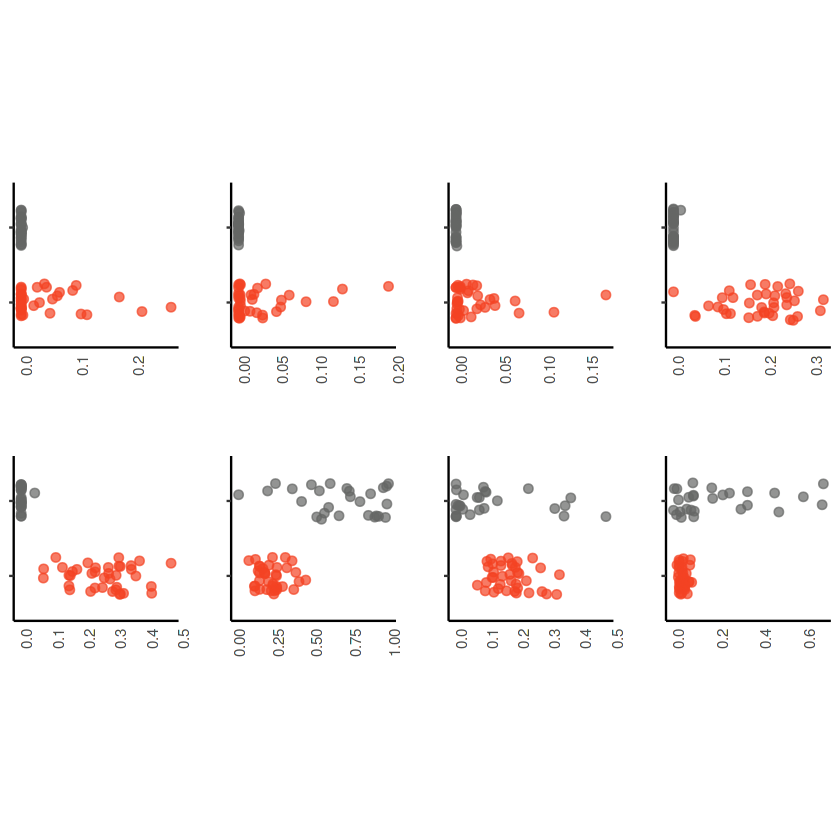

In [199]:
#labelled plot

ggplot(data=deconv, aes_string(x=Status, y='props')) +
geom_point(aes_string(fill = Status, color = Status), 
           size = 2, alpha = 0.7, 
           position = position_jitter(width=0.25, height=0)) +
  facet_wrap(~ celltype, scales = 'free', ncol = 4) + coord_flip()+
scale_color_manual(values = c('#f44323', '#656665')) + 
theme(aspect.ratio = 1/1) + 
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
#       axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") +
theme(strip.background = element_blank(), strip.text.x = element_blank(),
     panel.spacing.y = unit(3, "lines"), panel.spacing.x = unit(2, "lines"))+


theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


setwd('~/GCA_analysis/figures')

ggsave("bulk_deconv.png",   dpi = 300)

In [157]:
celltypes<-unique(deconv$celltype)

l<-list()
for(i in unique(celltypes)){
    temp<-deconv %>% filter(celltype == i)
    temp_result<-wilcox.test(filter(temp, !!as.symbol(Status) == Status1)$props, filter(temp, !!as.symbol(Status) == Status2)$props, alternative = "two.sided") 
    l[i]<-temp_result$p.value    
}

Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”


In [158]:
l

$VSMC
[1] 1.338444e-10

$MyoFB
[1] 0.0002445787

$Endothelium
[1] 0.0003221814

$CD4
[1] 1.857404e-06

$CD8
[1] 5.558427e-09

$NK
[1] 7.552509e-10

$DC
[1] 7.281985e-12

$Mac
[1] 2.141951e-12

In [200]:
p.adjust(l, 'BH')

VSMC        MyoFB  Endothelium          CD4          CD8           NK 
3.569183e-10 2.795185e-04 3.221814e-04 2.476538e-06 8.893483e-09 1.510502e-09 
          DC          Mac 
2.912794e-11 1.713561e-11